<a href="https://colab.research.google.com/github/giangto1/rice_image_classification/blob/main/rice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp drive/MyDrive/projects/dsprojects/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 92% 202M/219M [00:02<00:00, 107MB/s] 
100% 219M/219M [00:02<00:00, 101MB/s]


In [ ]:
! unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [ ]:
from pathlib import Path

In [ ]:
data_dir = Path('./Rice_Image_Dataset')
[x for x in data_dir.iterdir() if x.is_dir()]

[PosixPath('Rice_Image_Dataset/Arborio'),
 PosixPath('Rice_Image_Dataset/Karacadag'),
 PosixPath('Rice_Image_Dataset/Jasmine'),
 PosixPath('Rice_Image_Dataset/Ipsala'),
 PosixPath('Rice_Image_Dataset/Basmati')]

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

75000


In [ ]:
arborio = list(data_dir.glob('Arborio/*'))
karacadag = list(data_dir.glob('Karacadag/*'))
jasmine = list(data_dir.glob('Jasmine/*'))
ipsala = list(data_dir.glob('Ipsala/*'))
basmati = list(data_dir.glob('Basmati/*'))

#PIL.Image.open(str(arborio[0]))

Create Dataset (tf.data.Dataset object)

In [ ]:
batch_size = 16
img_height = 90
img_width = 90

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [ ]:
val_img = []
val_label = []
for image_batch, label_batch in val_ds:
    val_img.append(image_batch.numpy())
    val_label.append(label_batch.numpy())

In [ ]:
val_img = np.concatenate(val_img)
val_label = np.concatenate(val_label)

#print(val_img)

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


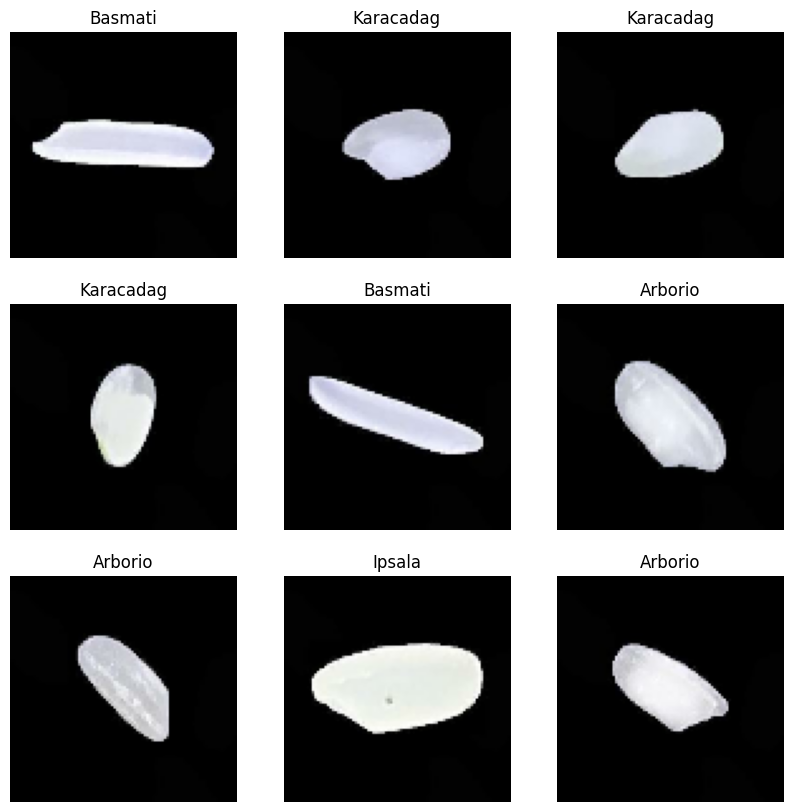

In [ ]:
import matplotlib.pyplot as plt
#randomly select 9 images in the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 90, 90, 3)
(16,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9725487


In [ ]:
model=keras.Sequential([
    keras.layers.Conv2D(64,kernel_size=(2,2),input_shape=(img_height, img_width, 3),activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(30,kernel_size=(2,2),activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(20,activation='relu'),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(5,activation='softmax'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 30)        7710      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 21, 30)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 13230)             0         
                                                                 
 dense_3 (Dense)             (None, 20)               

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 30)        7710      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 21, 30)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 13230)             0         
                                                                 
 dense_3 (Dense)             (None, 20)               

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3750/3750 [==============================] - 587s 156ms/step - loss: 0.0543 - accuracy: 0.9824 - val_loss: 0.0519 - val_accuracy: 0.9839
Epoch 2/10
3750/3750 [==============================] - 700s 187ms/step - loss: 0.0410 - accuracy: 0.9866 - val_loss: 0.0498 - val_accuracy: 0.9849
Epoch 3/10
3750/3750 [==============================] - 553s 147ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0534 - val_accuracy: 0.9859
Epoch 4/10
3750/3750 [==============================] - 547s 146ms/step - loss: 0.0296 - accuracy: 0.9902 - val_loss: 0.0501 - val_accuracy: 0.9859
Epoch 5/10
3750/3750 [==============================] - 548s 146ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.0601 - val_accuracy: 0.9831
Epoch 6/10
3750/3750 [==============================] - 549s 146ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0491 - val_accuracy: 0.9862
Epoch 7/10
3750/3750 [==============================] - 552s 147ms/step - loss: 0.0313 - accuracy: 0.9911 - val_

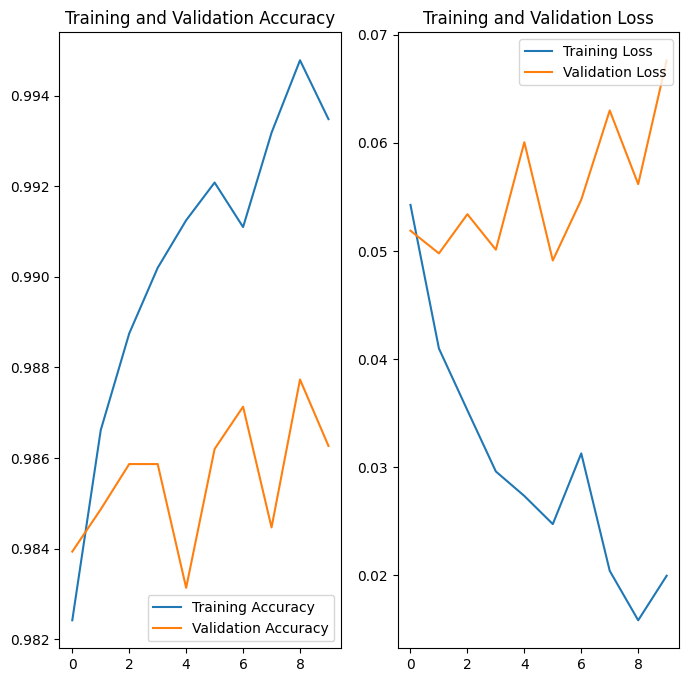

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

I started out by training and testing the model with 10 epochs, but the model overfits. Since there are 60k training images, I think the model has seen enough data with 2 epochs. Additionally, the neural network with 2 epochs yielded high accuracy of over 98% on both the train set and the test set.

### **Interact with model**

In [ ]:
predictions = model.predict(val_ds)

938/938 [==============================] - 34s 37ms/step


In [ ]:
for i in range(9):
  print(f'{i}: {class_names[np.argmax(predictions[i])]}')

0: Basmati
1: Arborio
2: Karacadag
3: Karacadag
4: Basmati
5: Karacadag
6: Ipsala
7: Jasmine
8: Jasmine


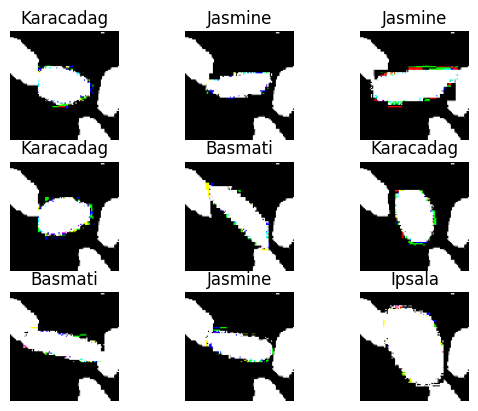

In [ ]:
# for images, labels in val_ds:
  #for i in range(5):
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(val_img[i])
  plt.title(class_names[val_label[i]])
  plt.axis("off")